# Car insurance - Modeling pure premium 

In [69]:
import os
import arff
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from xgboost import XGBRegressor

RANDOM_SEED = 42


### Data Exploration

In [70]:
data_dir = './data'

#   Part 1
data_freq = arff.load(os.path.join(data_dir, 'freMTPL2freq.arff'))

df_freq = pd.DataFrame(data_freq , columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower",
"VehAge", "DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"] )


display(df_freq.head())

print("Dataset size: ", len(df_freq))

print("IDpol has only unique values? ", (df_freq['IDpol'].nunique() == len(df_freq['IDpol'])))

display('Description of dataset: ', df_freq.describe(include='all'))



,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1.0,0.10,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82'
1,3.0,1.0,0.77,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82'
2,5.0,1.0,0.75,'B',6.0,2.0,52.0,50.0,'B12',Diesel,54.0,'R22'
3,10.0,1.0,0.09,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72'
4,11.0,1.0,0.84,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72'


Dataset size:  678013
IDpol has only unique values?  True


'Description of dataset: '

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
count,6.780130e+05,678013.000000,678013.000000,678013,678013.000000,678013.000000,678013.000000,678013.000000,678013,678013,678013.000000,678013
unique,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,11,2,NaN,22
top,NaN,NaN,NaN,'C',NaN,NaN,NaN,NaN,'B12',Regular,NaN,'R24'
freq,NaN,NaN,NaN,191880,NaN,NaN,NaN,NaN,166024,345877,NaN,160601
mean,2.621857e+06,0.053247,0.528750,NaN,6.454631,7.044265,45.499122,59.761502,NaN,NaN,1792.422405,NaN
std,1.641783e+06,0.240117,0.364442,NaN,2.050906,5.666232,14.137444,15.636658,NaN,NaN,3958.646564,NaN
min,1.000000e+00,0.000000,0.002732,NaN,4.000000,0.000000,18.000000,50.000000,NaN,NaN,1.000000,NaN
25%,1.157951e+06,0.000000,0.180000,NaN,5.000000,2.000000,34.000000,50.000000,NaN,NaN,92.000000,NaN
50%,2.272152e+06,0.000000,0.490000,NaN,6.000000,6.000000,44.000000,50.000000,NaN,NaN,393.000000,NaN
75%,4.046274e+06,0.000000,0.990000,NaN,7.000000,11.000000,55.000000,64.000000,NaN,NaN,1658.000000,NaN


In [71]:

#   Part 2

data_sev = arff.load(os.path.join(data_dir, 'freMTPL2sev.arff'))

df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"])


display(df_sev.head())

print("Dataset size: ", len(df_sev))

print("Percentage of IDpol-contracts with only one ClaimAmount: ", 
      round(df_sev['IDpol'].nunique()/len(df_sev['IDpol']), 4))

display('Description of dataset: ', df_sev.describe(include='all'))


print('Data types in ClaimAmount column:', df_sev["ClaimAmount"].apply(type).unique(), '\n')



,IDpol,ClaimAmount
0,1552.0,995.20
1,1010996.0,1128.12
2,4024277.0,1851.11
3,4007252.0,1204.00
4,4046424.0,1204.00


Dataset size:  26639
Percentage of IDpol-contracts with only one ClaimAmount:  0.9366


'Description of dataset: '

,IDpol,ClaimAmount
count,2.663900e+04,2.663900e+04
mean,2.279864e+06,2.278536e+03
std,1.577202e+06,2.929748e+04
min,1.390000e+02,1.000000e+00
25%,1.087642e+06,6.868100e+02
50%,2.137413e+06,1.172000e+03
75%,3.180162e+06,1.228080e+03
max,6.113971e+06,4.075401e+06


Data types in ClaimAmount column: [<class 'float'>] 



### Join data from both data tables

In [72]:
#   Sum up ClaimAmount for each distinct IDpol (contract)

df_sev_sum = df_sev.groupby(['IDpol'])[['ClaimAmount']].agg('sum').reset_index()

display(df_sev_sum)

,IDpol,ClaimAmount
0,139.0,303.00
1,190.0,1981.84
2,414.0,1456.55
3,424.0,10834.00
4,463.0,3986.67
...,...,...
24945,6113521.0,1324.40
24946,6113793.0,1769.88
24947,6113817.0,1288.28
24948,6113834.0,12230.40


In [73]:
#   Left join features table with ClaimAmount-table (containing unique IDpol)

df_combined = df_freq.merge(df_sev_sum, on="IDpol", how='left')

#   Fill None values of ClaimAmount with 0.0
df_combined["ClaimAmount"] = df_combined["ClaimAmount"].fillna(value=0.0)


#     Correct ClaimNb to 0 if ClaimAmount is 0 (assuming that ClaimAmount is ground truth)
df_combined["ClaimNb"] = np.where(df_combined["ClaimAmount"] == 0, 0, df_combined["ClaimNb"])


#   Construct the Pure Premium column (ClaimAmount / Exposure)
df_combined["ClaimAmount_Per_Year"] = df_combined["ClaimAmount"] / df_combined["Exposure"]

display(df_combined)

# TODO: drop 5% outliers w.r.t. certain columns?


print("Percentage of Policy Holders with no claims: ", 
      round(len(df_combined[df_combined["ClaimNb"] == 0.0]) / len(df_combined), 4))


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,ClaimAmount_Per_Year
0,1.0,0.0,0.10000,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82',0.0,0.0
1,3.0,0.0,0.77000,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82',0.0,0.0
2,5.0,0.0,0.75000,'B',6.0,2.0,52.0,50.0,'B12',Diesel,54.0,'R22',0.0,0.0
3,10.0,0.0,0.09000,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72',0.0,0.0
4,11.0,0.0,0.84000,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72',0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326.0,0.0,0.00274,'E',4.0,0.0,54.0,50.0,'B12',Regular,3317.0,'R93',0.0,0.0
678009,6114327.0,0.0,0.00274,'E',4.0,0.0,41.0,95.0,'B12',Regular,9850.0,'R11',0.0,0.0
678010,6114328.0,0.0,0.00274,'D',6.0,2.0,45.0,50.0,'B12',Diesel,1323.0,'R82',0.0,0.0
678011,6114329.0,0.0,0.00274,'B',4.0,0.0,60.0,50.0,'B12',Regular,95.0,'R26',0.0,0.0


Percentage of Policy Holders with no claims:  0.9632


In [74]:
#   Check if num of IDpols is correct

if len(df_combined) != len(df_freq):
    raise Exception("Wrong dimensions for df_combined")

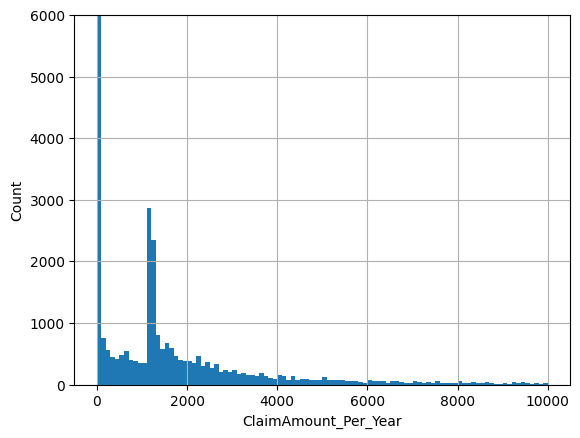

In [75]:
#   Histogram for ClaimAmount_Per_Year

df_combined["ClaimAmount_Per_Year"].hist(bins=100, range=(0, 1e4))

plt.gca().set_ylim([0, 6000])
plt.xlabel('ClaimAmount_Per_Year')
plt.ylabel('Count')
plt.show()

In [76]:
display(df_combined)

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,ClaimAmount_Per_Year
0,1.0,0.0,0.10000,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82',0.0,0.0
1,3.0,0.0,0.77000,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82',0.0,0.0
2,5.0,0.0,0.75000,'B',6.0,2.0,52.0,50.0,'B12',Diesel,54.0,'R22',0.0,0.0
3,10.0,0.0,0.09000,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72',0.0,0.0
4,11.0,0.0,0.84000,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72',0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326.0,0.0,0.00274,'E',4.0,0.0,54.0,50.0,'B12',Regular,3317.0,'R93',0.0,0.0
678009,6114327.0,0.0,0.00274,'E',4.0,0.0,41.0,95.0,'B12',Regular,9850.0,'R11',0.0,0.0
678010,6114328.0,0.0,0.00274,'D',6.0,2.0,45.0,50.0,'B12',Diesel,1323.0,'R82',0.0,0.0
678011,6114329.0,0.0,0.00274,'B',4.0,0.0,60.0,50.0,'B12',Regular,95.0,'R26',0.0,0.0


### Splitting data

In [77]:

X_train, X_test, Y_train, Y_test = train_test_split(df_combined.drop(columns=["IDpol", "ClaimNb", "Exposure", "ClaimAmount", "ClaimAmount_Per_Year"]), 
                                                    df_combined[["ClaimNb", "Exposure", "ClaimAmount", "ClaimAmount_Per_Year"]], 
                                                    test_size=0.2, 
                                                    shuffle=True,
                                                    random_state=RANDOM_SEED
                                                    )

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, 
                                                      Y_train, 
                                                      test_size=0.2, 
                                                      shuffle=True,
                                                      random_state=RANDOM_SEED
                                                    )

print("Shape of X_train: ", X_train.shape, " Shape of Y_train: ", Y_train.shape)

print("Shape of X_test: ", X_test.shape, " Shape of Y_test: ", Y_test.shape)

print("Shape of X_valid: ", X_valid.shape, " Shape of Y_valid: ", Y_valid.shape)


Shape of X_train:  (433928, 9)  Shape of Y_train:  (433928, 4)
Shape of X_test:  (135603, 9)  Shape of Y_test:  (135603, 4)
Shape of X_valid:  (108482, 9)  Shape of Y_valid:  (108482, 4)


### Create features (Encoding and Scaling) and labels

In [78]:


def get_feature_transformer(X_train):

    #   Binning, Encoding and Scaling of certain columns

    log_scale_transformer = make_pipeline(
        FunctionTransformer(func=np.log), StandardScaler()
    )

    column_trans = ColumnTransformer(
        [
            (
                "binned_numeric",
                KBinsDiscretizer(n_bins=10, subsample=int(2e5), random_state=RANDOM_SEED),
                ["VehAge", "DrivAge"],
            ),
            (
                "onehot_categorical",
                OneHotEncoder(),
                ["VehBrand", "VehGas", "Region", "Area"],
            ),
            ("passthrough_numeric", "passthrough", ["BonusMalus"]),
            ("log_scaled_numeric", log_scale_transformer, ["Density"]),
        ]
    )

    column_trans.fit(X_train)

    return column_trans



column_trans = get_feature_transformer(X_train)


X_train = column_trans.transform(X_train).toarray()
X_test = column_trans.transform(X_test).toarray()
X_valid = column_trans.transform(X_valid).toarray()


transformed_columns = []

for name, transformer, columns in column_trans.transformers_:
    if isinstance(transformer, KBinsDiscretizer):
        #   KBinsDiscretizer replaces 2 cols with 20 cols
        transformed_columns.extend(transformer.get_feature_names_out(input_features=columns))
    elif isinstance(transformer, OneHotEncoder):
        #   OneHotEncoder replaces 5 cols with 53 cols
        transformed_columns.extend(transformer.get_feature_names_out(input_features=columns))
    else:
        #   passthrough and log_scale_transformer replace their column
        transformed_columns.extend(columns)



### Create and fit model

In [79]:
# Using Gradient boosted decision trees: XGBoost

default_params = {
    "objective": "reg:tweedie",
    "tweedie_variance_power": 1.1,  #   Closer to Poisson -> large number of 0.0
    'n_estimators': 1000,
    "learning_rate": 0.02,
    "max_depth": 18,
    "early_stopping_rounds": 50,
    "random_state": RANDOM_SEED,    
}


model = XGBRegressor(**default_params)

model.fit(X=X_train, 
            y=Y_train["ClaimAmount_Per_Year"], 
            sample_weight=Y_train["Exposure"],
            eval_set=[(X_valid, Y_valid["ClaimAmount_Per_Year"])]
            )

print("Best model iteration (final model): ", model.best_iteration)


print("Hyperparameters: ", default_params)


[0]	validation_0-tweedie-nloglik@1.1:6503.78891
[1]	validation_0-tweedie-nloglik@1.1:6399.67963
[2]	validation_0-tweedie-nloglik@1.1:6297.75203
[3]	validation_0-tweedie-nloglik@1.1:6197.90595
[4]	validation_0-tweedie-nloglik@1.1:6100.06864
[5]	validation_0-tweedie-nloglik@1.1:6004.25758
[6]	validation_0-tweedie-nloglik@1.1:5910.42971
[7]	validation_0-tweedie-nloglik@1.1:5818.53547
[8]	validation_0-tweedie-nloglik@1.1:5728.50083
[9]	validation_0-tweedie-nloglik@1.1:5640.32073
[10]	validation_0-tweedie-nloglik@1.1:5553.99721
[11]	validation_0-tweedie-nloglik@1.1:5469.34903
[12]	validation_0-tweedie-nloglik@1.1:5386.51680
[13]	validation_0-tweedie-nloglik@1.1:5305.36252
[14]	validation_0-tweedie-nloglik@1.1:5225.88426
[15]	validation_0-tweedie-nloglik@1.1:5148.09995
[16]	validation_0-tweedie-nloglik@1.1:5071.94886
[17]	validation_0-tweedie-nloglik@1.1:4997.31551
[18]	validation_0-tweedie-nloglik@1.1:4924.29236
[19]	validation_0-tweedie-nloglik@1.1:4852.80172
[20]	validation_0-tweedie-nlog

### Evaluation of model

Performance on train data 

 Mean Absolute Error (train): 476.91
 Mean Absolute Percentage Error (train): 1.1898386175165043e+18


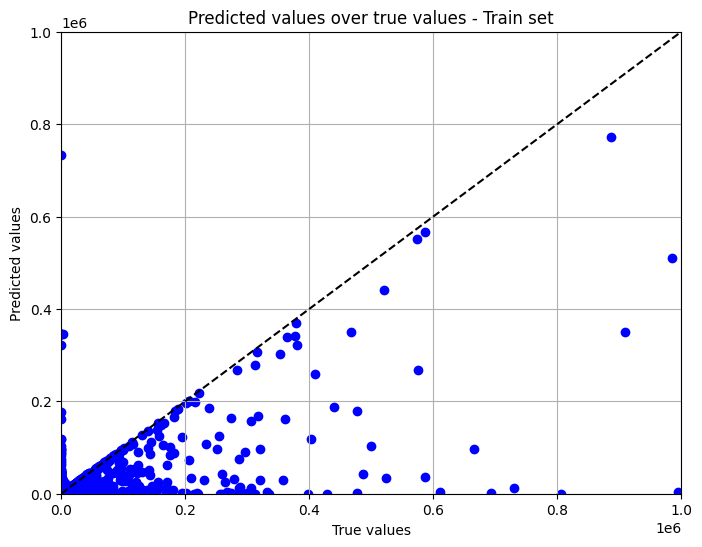

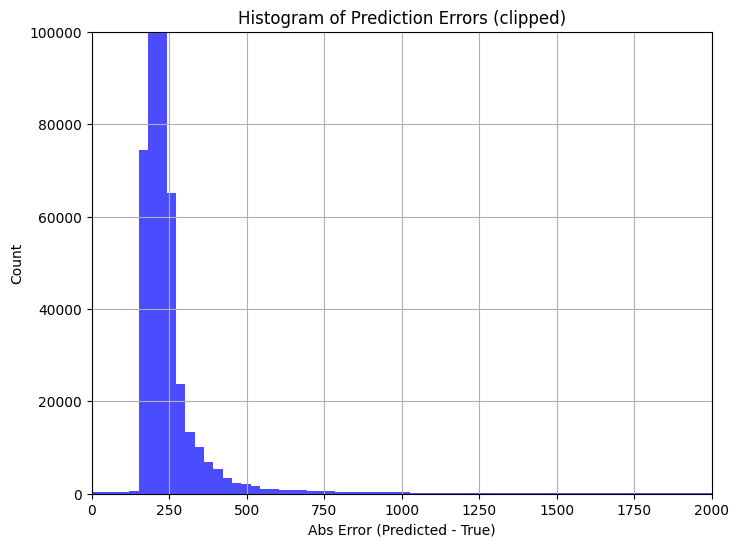

In [80]:
#   Performance on train data

train_preds = model.predict(X_train)
train_trues = Y_train["ClaimAmount_Per_Year"]

mae_train = mean_absolute_error(train_trues, train_preds)
mape_train = mean_absolute_percentage_error(train_trues, train_preds)

print("Performance on train data \n")
print(" Mean Absolute Error (train):", round(mae_train, 2))
print(" Mean Absolute Percentage Error (train):", round(mape_train, 4))


plt.figure(figsize=(8, 6))
plt.scatter(train_trues, train_preds, color='blue')
plt.plot([train_trues.min(), train_trues.max()], 
         [train_trues.min(), train_trues.max()], 
         color='black', 
         linestyle='--')
plt.title('Predicted values over true values - Train set')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.xlim(0, 1e6)
plt.ylim(0, 1e6)
plt.grid(True)
plt.show()



errors = np.abs(train_preds - train_trues)

# Plotting histogram
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=100000, alpha=0.7, color='blue')
plt.title('Histogram of Prediction Errors (clipped)')
plt.xlabel('Abs Error (Predicted - True)')
plt.ylabel('Count')
plt.xlim(0, 2e3)
plt.ylim(0, 1e5)
plt.grid(True)
plt.show()




Performance on test data 

Mean Absolute Error (test): 737.07
Mean Absolute Percentage Error (test): 1.459228475340558e+18


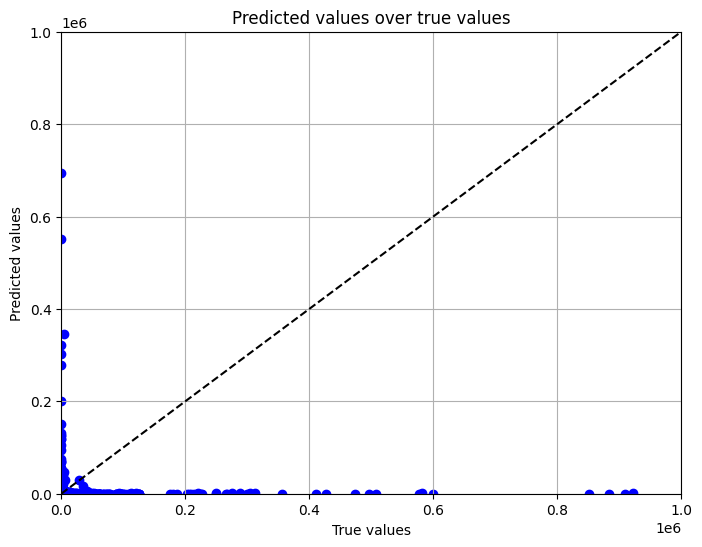

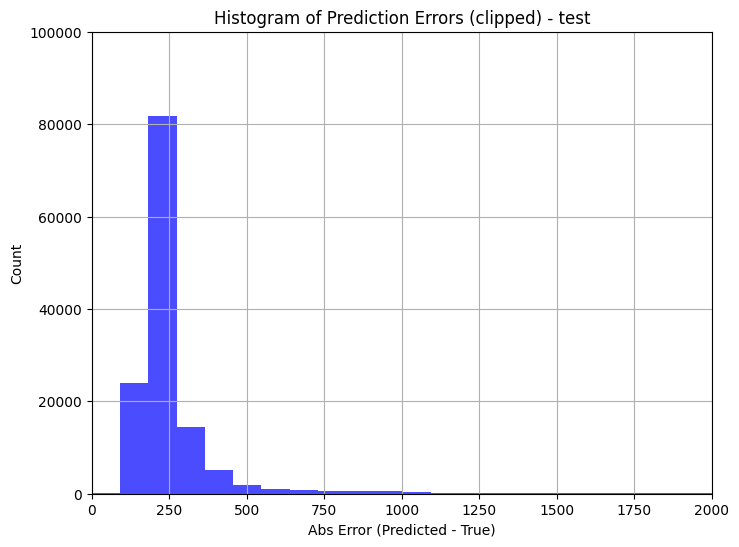

In [81]:
#   Performance test data

test_preds = model.predict(X_test)
test_trues = Y_test["ClaimAmount_Per_Year"]

mae_test = mean_absolute_error(test_trues, test_preds)
mape_test = mean_absolute_percentage_error(test_trues, test_preds)

print("Performance on test data \n")
print("Mean Absolute Error (test):", round(mae_test, 2))
print("Mean Absolute Percentage Error (test):", round(mape_test, 4))


plt.figure(figsize=(8, 6))
plt.scatter(test_trues, test_preds, color='blue')
plt.plot([test_trues.min(), test_trues.max()], 
         [test_trues.min(), test_trues.max()], 
         color='black', 
         linestyle='--')
plt.title('Predicted values over true values')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.xlim(0, 1e6)
plt.ylim(0, 1e6)
plt.grid(True)
plt.show()


errors = np.abs(test_preds - test_trues)

# Plotting histogram
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=100000, alpha=0.7, color='blue')
plt.title('Histogram of Prediction Errors (clipped) - test')
plt.xlabel('Abs Error (Predicted - True)')
plt.ylabel('Count')
plt.xlim(0, 2e3)
plt.ylim(0, 1e5)
plt.grid(True)
plt.show()



### Feature Importance

[('VehAge_8.0', 0.12412152), ("Area_'B'", 0.097088896), ('DrivAge_0.0', 0.04310315), ("Region_'R24'", 0.042242944), ('BonusMalus', 0.0328389), ('Density', 0.026127242), ("VehBrand_'B4'", 0.023671178), ('VehAge_9.0', 0.023271443), ('DrivAge_8.0', 0.021266388), ("Region_'R82'", 0.021046933), ("Region_'R94'", 0.020415856), ("Region_'R53'", 0.019582773), ('DrivAge_9.0', 0.017344067), ('VehAge_2.0', 0.017070329), ("VehBrand_'B3'", 0.015857924), ("VehBrand_'B12'", 0.015814545), ('VehAge_3.0', 0.014011161), ("Region_'R25'", 0.013905439), ('DrivAge_2.0', 0.013857609), ("Region_'R93'", 0.013056569), ("VehBrand_'B13'", 0.0129506225), ("VehBrand_'B1'", 0.01264516), ("Region_'R91'", 0.012607143), ("VehBrand_'B2'", 0.012169945), ('VehAge_4.0', 0.011784821), ('DrivAge_5.0', 0.011712444), ('VehGas_Diesel', 0.011664839), ("VehBrand_'B5'", 0.011483126), ('VehAge_5.0', 0.010975217), ('VehAge_6.0', 0.010664309), ("Area_'D'", 0.01056411), ("Area_'C'", 0.010342487), ("Area_'A'", 0.010295632), ('DrivAge_1.0

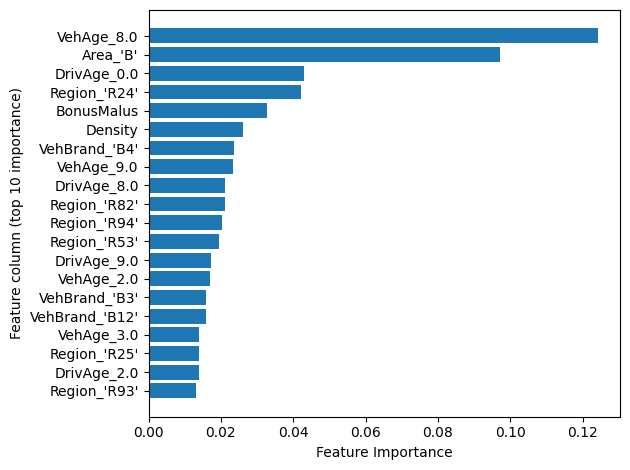

In [82]:
#   Get most important features and their importance

feature_importances_dict = dict(zip(transformed_columns, model.feature_importances_))

#   Sort by value
feature_importances_sorted= sorted(feature_importances_dict.items(), 
                                   key=lambda item: item[1], 
                                   reverse=True)
print(feature_importances_sorted)

#   Keep only top 20
feature_importances = dict(feature_importances_sorted[0:20])

#   Plot feature importances

fig, ax = plt.subplots()

plt.barh(list(reversed(feature_importances.keys())), 
         list(reversed(feature_importances.values())))

ax.set_xlabel("Feature Importance")
ax.set_ylabel("Feature column (top 10 importance)")
fig.tight_layout()

plt.show()

### Towards model improvement

- Drop outliers in dataset
- Train model on Principal component analysis (PCA) transformed training data (-> fit PCA model)


